# Smoothed ridge regression

In [1]:
library(tidyverse)

#install.packages('hablar')
#library(hablar)

#install.packages("tidyr")
#install.packages("rlang")
library(tidyr)

#install.packages('scales')
library(scales)

library(LICORS)

#install.packages("slider")
library(slider)

library(glmnet)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accum

## Reading in the data

In [2]:
sum_control_ATAC_bin_rm_sliding_mean <- read.csv("sum_control_ATAC_bin_rm_sliding_mean.csv")
sum_control_ATAC_bin_rm = read.csv("sum_control_ATAC_bin_rm.csv")

ATAC_val <- sum_control_ATAC_bin_rm %>% select(ATAC_val)

sum_control_ATAC = read.csv("sum_control_ATAC.csv")

In [3]:
head(sum_control_ATAC_bin_rm_sliding_mean)

X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
1.449941e-06,1.491368e-06,1.522438e-06,1.353278e-06,1.478940e-06,1.423579e-06,1.581754e-06,1.581754e-06,1.502666e-06,1.581754e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8.313727e-07,8.313727e-07,1.454902e-06,1.662745e-06,1.829020e-06,2.040642e-06,2.116221e-06,2.342959e-06,2.494118e-06,2.645277e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7.254811e-07,9.949456e-07,1.305866e-06,1.160770e-06,1.131751e-06,1.028864e-06,1.028864e-06,9.497208e-07,1.108008e-06,1.108008e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.914340e-08,8.705774e-08,9.673082e-08,1.088222e-07,1.243682e-07,1.450962e-07
8.503423e-07,8.503423e-07,7.440495e-07,7.558598e-07,7.653081e-07,7.730385e-07,8.503423e-07,8.503423e-07,9.276462e-07,8.503423e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3.138859e-07,4.035676e-07,3.531216e-07,6.277718e-07,5.649946e-07,7.704472e-07,8.560525e-07,1.198473e-06,1.369684e-06,1.455289e-06,...,8.560525e-08,8.560525e-08,8.560525e-08,8.560525e-08,8.560525e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1.266337e-06,1.206035e-06,1.055281e-06,1.219435e-06,1.097492e-06,1.151215e-06,1.151215e-06,1.151215e-06,1.227963e-06,9.977199e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Ridge regression

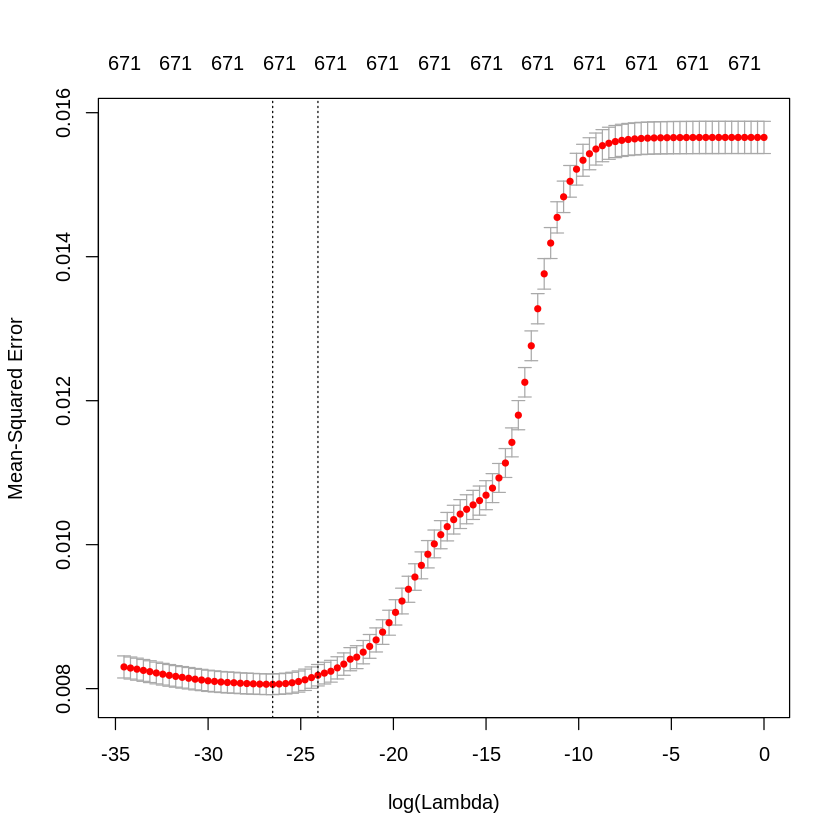

In [12]:
set.seed(0)
#X==predictor
#y==response
#sum_control_ATAC_bin_rm <- sum_control_ATAC  %>% dplyr::select(-bin)



y <- ATAC_val %>%  as.matrix()
X <- sum_control_ATAC_bin_rm_sliding_mean %>% as.matrix()

lambdas_to_try <- 10^seq(-15, 0, length.out = 100)
#standardize = FALSE -- range 
#standardize = TRUE -- range 


ridge_cv_smooth <- cv.glmnet(X, y, alpha = 0, lambda = lambdas_to_try,
                      standardize = FALSE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(ridge_cv_smooth)

In [13]:
lambda_cv_ridge_smooth <- ridge_cv_smooth$lambda.min

In [14]:
CV_ridge_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- sum_control_ATAC_bin_rm_sliding_mean %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 0, lambda = lambda_cv_ridge_smooth, standardize = FALSE)
        tmp       <- predict(fit, s=lambda_cv_ridge_smooth, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [15]:
res_ridge_smooth_pred <- CV_ridge_smooth(sum_control_ATAC_bin_rm_sliding_mean, 10)

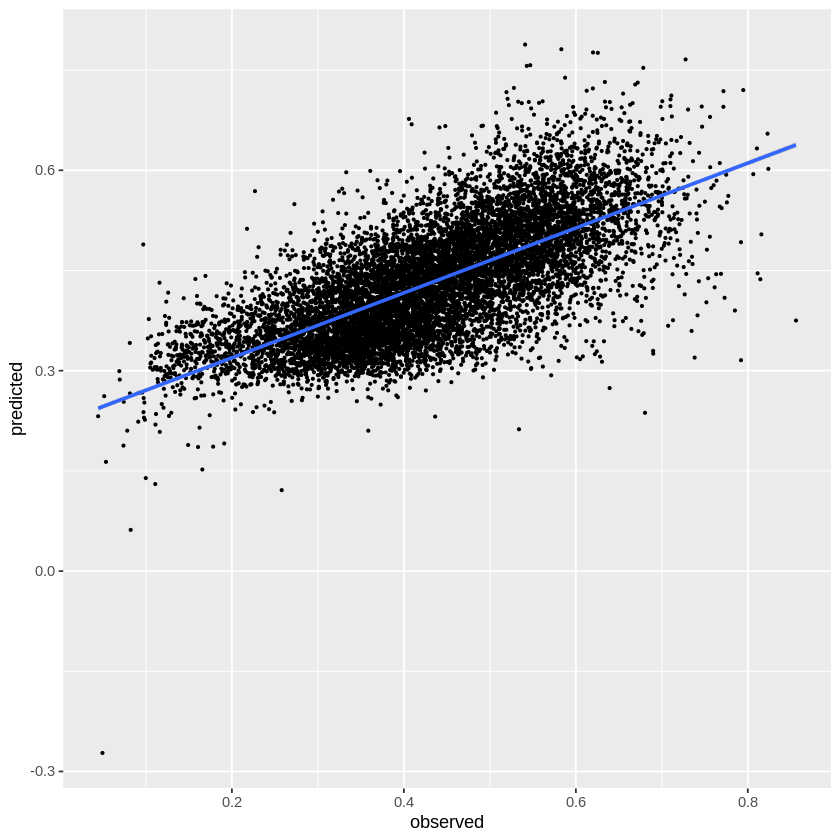

In [16]:
ggplot(res_ridge_smooth_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [17]:
cor(res_ridge_smooth_pred$observed, res_ridge_smooth_pred$predicted)

# Standardize = TRUE: ATAC_val 0.6851758
# Standardize = FALSE: ATAC_val 0.695823


ATAC_val,0.695823
